### Generalized Surrogates

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/phase_coupling_analysis")

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pycircular
import seaborn as sns
import xarray as xr
from frites.conn import conn_reshape_undirected
from frites.utils import parallel_func
from scipy.signal import find_peaks
from scipy.stats import circmean, circstd, circvar
from sklearn.metrics import euclidean_distances
from tqdm import tqdm
from src.signal.surrogates import trial_swap_surrogates


from src.util import _extract_roi

#### Functions

In [6]:
def circular_hist(
    ax, x, bins=16, density=True, offset=0, gaps=True, fill=False, alpha=0.3, color="b"
):
    """
    Produce a circular histogram of angles on ax.

    Parameters
    ----------
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        axis instance created with subplot_kw=dict(projection='polar').

    x : array
        Angles to plot, expected in units of radians.

    bins : int, optional
        Defines the number of equal-width bins in the range. The default is 16.

    density : bool, optional
        If True plot frequency proportional to area. If False plot frequency
        proportional to radius. The default is True.

    offset : float, optional
        Sets the offset for the location of the 0 direction in units of
        radians. The default is 0.

    gaps : bool, optional
        Whether to allow gaps between bins. When gaps = False the bins are
        forced to partition the entire [-pi, pi] range. The default is True.

    Returns
    -------
    n : array or list of arrays
        The number of values in each bin.

    bins : array
        The edges of the bins.

    patches : `.BarContainer` or list of a single `.Polygon`
        Container of individual artists used to create the histogram
        or list of such containers if there are multiple input datasets.
    """
    # Wrap angles to [-pi, pi)
    x = (x + np.pi) % (2 * np.pi) - np.pi

    # Force bins to partition entire circle
    if not gaps:
        bins = np.linspace(-np.pi, np.pi, num=bins + 1)

    # Bin data and record counts
    n, bins = np.histogram(x, bins=bins)

    # Compute width of each bin
    widths = np.diff(bins)

    # By default plot frequency proportional to area
    if density:
        # Area to assign each bin
        area = n / x.size
        # Calculate corresponding bin radius
        radius = (area / np.pi) ** 0.5
    # Otherwise plot frequency proportional to radius
    else:
        radius = n

    # Plot data on ax
    patches = ax.bar(
        bins[:-1],
        radius,
        zorder=1,
        align="edge",
        width=widths,
        edgecolor="k",
        fill=fill,
        linewidth=1,
        alpha=alpha,
        color=color,
    )

    # Set the direction of the zero angle
    ax.set_theta_offset(offset)

    # Remove ylabels for area plots (they are mostly obstructive)
    if density:
        ax.set_yticks([])

    return n, bins, patches

In [15]:
from frites.conn import conn_io

def _phase_diff(w, x_s, x_t, kw_para):
    def pairwise_phase_diff(w_x, w_y):
        return np.unwrap(w[:, w_x, :, :] - w[:, w_y, :, :])

    # define the function to compute in parallel
    parallel, p_fun = parallel_func(pairwise_phase_diff, **kw_para)

    # compute the single trial coherence
    return parallel(p_fun(s, t) for s, t in zip(x_s, x_t))

#### Load data

In [8]:
DATA_PATH = os.path.expanduser("~/Documents/phaseanalysis/Results/lucy/141017")

phase_time_series = xr.load_dataarray(
    os.path.join(DATA_PATH, "phase_time_series_surr_False.nc")
)

power_time_series = xr.load_dataarray(
    os.path.join(DATA_PATH, "power_time_series_surr_False.nc")
)

#### Generate surrogate data

In [6]:
n_boot = 1000
count = 0


def shuffle_along_axis(a, axis):
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a, idx, axis=axis)


data = phase_time_series.values.copy()

trials_surr = []
while count < n_boot:
    out = np.random.choice(
        range(phase_time_series.sizes["trials"]),
        size=2,
        replace=True,
    )

    if out[0] == out[1]:
        continue
    else:
        trials_surr += [out]
        count = count + 1
trials_surr = np.stack(trials_surr)

count = 0
channels_surr = []
while count < n_boot:
    out = np.random.choice(
        range(phase_time_series.sizes["roi"]),
        size=2,
        replace=True,
    )

    if out[0] == out[1]:
        continue
    else:
        channels_surr += [out]
        count = count + 1
channels_surr = np.stack(channels_surr)

data_surr = []
for c_i, c_j, trial_i, trial_j in tqdm(
    np.concatenate((channels_surr, trials_surr), axis=1)
):
    x = data[trial_i, c_i]
    y = data[trial_j, c_j][..., ::-1]
    # y = shuffle_along_axis(y, axis=1)
    data_surr += [np.stack((x, y))]

data_surr = np.stack(data_surr)

100%|█████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 43367.67it/s]


In [16]:
phi_series = np.unwrap( data_surr[:, 0] - data_surr[:, 1] )[:, 1]

(array([17663, 17695, 17771, 17796, 17541, 17510, 17756, 17604, 17455,
        17667, 17671, 17502, 17807, 17793, 17593, 17854, 17812, 17539,
        17654, 17619, 17693, 17457, 17722, 17596, 17698, 17741, 17650,
        17626, 17780, 17735]),
 array([-3.14156597e+00, -2.93212941e+00, -2.72269284e+00, -2.51325627e+00,
        -2.30381970e+00, -2.09438314e+00, -1.88494657e+00, -1.67551000e+00,
        -1.46607343e+00, -1.25663687e+00, -1.04720030e+00, -8.37763730e-01,
        -6.28327162e-01, -4.18890595e-01, -2.09454027e-01, -1.74595731e-05,
         2.09419108e-01,  4.18855676e-01,  6.28292243e-01,  8.37728811e-01,
         1.04716538e+00,  1.25660195e+00,  1.46603851e+00,  1.67547508e+00,
         1.88491165e+00,  2.09434822e+00,  2.30378478e+00,  2.51322135e+00,
         2.72265792e+00,  2.93209449e+00,  3.14153105e+00]),
 <BarContainer object of 30 artists>)

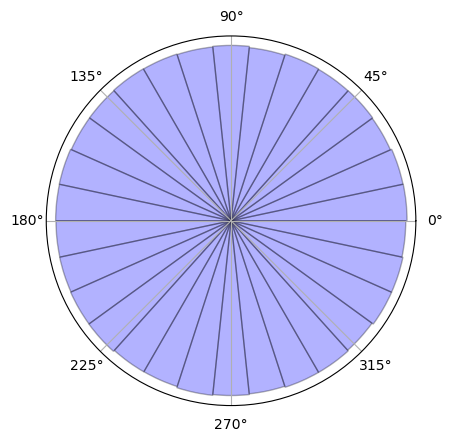

In [23]:
ax = plt.subplot(111, projection="polar")

circular_hist(
    ax, phi_series.flatten(), bins=30, density=True, offset=0, gaps=True, fill=True, alpha=0.3, color="b"
)

In [13]:
phase_time_series_surrogate = trial_swap_surrogates(phase_time_series.isel(freqs=1))

In [14]:
kw_para = dict(n_jobs=n_jobs, verbose=verbose, total=n_pairs)
delta_phase = np.stack(_phase_diff(phase, x_s, x_t, kw_para), axis=1)

<xarray.DataArray (trials: 398, roi: 82, times: 530)> Size: 138MB
array([[[-1.57079633, -1.45982987, -1.31652715, ..., -2.46186886,
         -2.19105986, -1.88271729],
        [ 1.57079633, -0.26150281,  0.01345529, ...,  1.23181738,
          1.37941861,  1.48445141],
        [ 1.57079633,  1.3730963 ,  1.36010684, ...,  1.50781696,
          1.60170886,  1.61234676],
        ...,
        [ 1.57079633,  1.66498135,  1.78007452, ...,  0.90034029,
          1.11637457,  1.3515696 ],
        [-1.57079633, -1.12213414, -0.78113177, ..., -1.53829821,
         -1.44481422, -1.49585107],
        [-1.57079633, -1.08342983, -0.76613381, ..., -0.15125489,
         -0.09686083, -0.57537996]],

       [[ 1.57079633,  1.1791287 ,  0.55810613, ...,  0.25424646,
          0.63057386,  1.06396594],
        [ 1.57079633,  3.02796405, -2.8242625 , ..., -1.67460162,
         -1.63152088, -1.59829132],
        [-1.57079633, -1.36418401, -1.15659977, ..., -2.21821065,
         -1.98527695, -1.75722214],
...
        [ 1.57079633,  1.92911812,  2.20980284, ...,  1.89612997,
          1.80751225,  1.66852615],
        [-1.57079633, -1.58076458, -1.52814741, ..., -0.84263754,
         -0.76522243, -1.02268691],
        [ 1.57079633,  2.35507213,  2.66916312, ..., -2.43100152,
         -2.26384142, -2.06303599]],

       [[ 1.57079633,  1.84247629,  2.07116953, ...,  0.28897472,
          0.8826584 ,  1.30870041],
        [-1.57079633, -2.3456652 , -2.03986748, ...,  1.20505834,
          1.47469695,  3.0200155 ],
        [-1.57079633, -1.30515056, -1.01260544, ..., -2.41846001,
         -2.1384684 , -1.83964182],
        ...,
        [ 1.57079633,  1.80978769,  2.02660806, ...,  1.74552223,
          1.78762125,  1.70371867],
        [-1.57079633,  2.52982012,  2.66498732, ..., -2.42405578,
         -2.22944142, -1.9793915 ],
        [-1.57079633, -2.72999785,  2.61666107, ..., -2.62312008,
         -2.35179836, -2.01666718]]])
Coordinates:
  * trials   (trials) int64 3kB 2 4 6 9 10 13 14 ... 606 617 634 635 638 646 652
  * roi      (roi) <U8 3kB 'a46D_1' 'a8B_4' 'F6_8' ... 'V1_250' 'V1_251'
    freqs    int64 8B 10
  * times    (times) float64 4kB -0.65 -0.645 -0.64 -0.635 ... 1.985 1.99 1.995